<a href="https://colab.research.google.com/github/Willian-BC/Projeto-Final/blob/main/Projeto_DataScience.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Configurações Iniciais e download

In [ ]:
!pip install wget

In [2]:
import pandas as pd
import numpy as np
import wget
from zipfile import ZipFile
from google.colab.data_table import DataTable
import plotly.graph_objects as go
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from subprocess import check_output

In [ ]:
url_base = 'http://dados.cvm.gov.br/dados/CIA_ABERTA/DOC/DFP/DADOS/'
arquivos_zip = []
for ano in range(2010, 2021, 10):
  arquivos_zip.append(f'dfp_cia_aberta_{ano}.zip')

for arq in arquivos_zip:
  wget.download(url_base+arq)
  ZipFile(arq, 'r').extractall('CVM')

arquivos_zip

#Tratamento DataFrame

In [ ]:
dre_10 = pd.read_csv(f'CVM/dfp_cia_aberta_DRE_ind_2010.csv',sep=';',decimal=',',encoding='ISO-8859-1')
dre_10.head()

In [ ]:
dre_10.info()

In [37]:
dre_10 = dre_10[dre_10.ORDEM_EXERC == 'ÚLTIMO']
dre_10 = dre_10[dre_10.DS_CONTA.isin(['Lucro ou Prejuízo Líquido do Período','Despesas com Pessoal','Outras Despesas de Administrativas','Despesas Tributárias',
                                      'Outras Receitas Operacionais','Outras Despesas Operacionais','Resultado antes dos Tributos sobre o Lucro',
                                      'Corrente','Participações'])]
dre_10 = dre_10[['CD_CVM','CNPJ_CIA','DENOM_CIA','MOEDA','ESCALA_MOEDA','DT_INI_EXERC','DT_FIM_EXERC','DS_CONTA','VL_CONTA']] 
dre_10.VL_CONTA = dre_10.VL_CONTA.astype(float)
dre_10 = dre_10.pivot_table(index=['CD_CVM','CNPJ_CIA','DENOM_CIA','MOEDA','ESCALA_MOEDA','DT_INI_EXERC','DT_FIM_EXERC'], columns=['DS_CONTA'], values='VL_CONTA').reset_index().rename_axis(None, axis=1).fillna(0)

dre_20 = pd.read_csv(f'CVM/dfp_cia_aberta_DRE_ind_2020.csv',sep=';',decimal=',',encoding='ISO-8859-1')
dre_20 = dre_20[dre_20.ORDEM_EXERC == 'ÚLTIMO']

dre_10['Resultado'] = dre_10.CNPJ_CIA.isin(dre_20.CNPJ_CIA).replace({True: 'Não Faliu', False: 'Faliu'})

In [ ]:
color_list = ['red' if i=='Faliu' else 'green' for i in dre_10.loc[:,'Resultado']]
pd.plotting.scatter_matrix(dre_10.loc[:, dre_10.columns != 'Resultado'],
                                       c=color_list,
                                       figsize= [15,15],
                                       diagonal='hist',
                                       alpha=0.5,
                                       s = 200,
                                       marker = '*',
                                       edgecolor= "black")
plt.show()

In [ ]:
sns.countplot(x="Resultado", data=dre_10)
dre_10.loc[:,'Resultado'].value_counts()

# Reference
https://www.kaggle.com/kanncaa1/machine-learning-tutorial-for-beginners

#KNN

In [ ]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 3)
x,y = dre_10.loc[:,['Outras Despesas Operacionais','Outras Receitas Operacionais']], dre_10.loc[:,'Resultado']
knn.fit(x,y)
prediction = knn.predict(x)
print('Prediction: {}'.format(prediction))

In [ ]:
# train test split
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.3,random_state = 1)
knn = KNeighborsClassifier(n_neighbors = 3)
x,y = dre_10.loc[:,dre_10.columns != 'Resultado'], dre_10.loc[:,'Resultado']
knn.fit(x_train,y_train)
prediction = knn.predict(x_test)
#print('Prediction: {}'.format(prediction))
print('With KNN (K=3) accuracy is: ',knn.score(x_test,y_test)) # accuracy

In [ ]:
# Model complexity
neig = np.arange(1, 25)
train_accuracy = []
test_accuracy = []
# Loop over different values of k
for i, k in enumerate(neig):
    # k from 1 to 25(exclude)
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train,y_train)
    train_accuracy.append(knn.score(x_train, y_train))
    test_accuracy.append(knn.score(x_test, y_test))

# Plot
plt.figure(figsize=[13,8])
plt.plot(neig, test_accuracy, label = 'Testing Accuracy')
plt.plot(neig, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.title('-value VS Accuracy')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.xticks(neig)
plt.savefig('graph.png')
plt.show()
print("Best accuracy is {} with K = {}".format(np.max(test_accuracy),1+test_accuracy.index(np.max(test_accuracy))))

#Regressão

In [ ]:
df = dre_10[dre_10['Resultado'] =='Faliu']
x = np.array(df.loc[:,'Outras Despesas Operacionais']).reshape(-1,1)
y = np.array(df.loc[:,'Outras Receitas Operacionais']).reshape(-1,1)
# Scatter
plt.figure(figsize=[10,10])
plt.scatter(x=x,y=y)
plt.xlabel('Outras Despesas Operacionais')
plt.ylabel('Outras Receitas Operacionais')
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
predict_space = np.linspace(min(x), max(x)).reshape(-1,1)
reg.fit(x,y)
predicted = reg.predict(predict_space)
print('R^2 score: ',reg.score(x, y))
# Plot regression line and scatter
plt.plot(predict_space, predicted, color='black', linewidth=3)
plt.scatter(x=x,y=y)
plt.xlabel('Outras Despesas Operacionais')
plt.ylabel('Outras Receitas Operacionais')
plt.show()

#Validação

In [ ]:
# Cross Validation
from sklearn.model_selection import cross_val_score
reg = LinearRegression()
k = 5
cv_result = cross_val_score(reg,x,y,cv=k) # uses R^2 as score 
print('CV Scores: ',cv_result)
print('CV scores average: ',np.sum(cv_result)/k)

In [ ]:
# Ridge
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state = 2, test_size = 0.3)
ridge = Ridge(alpha = 0.1, normalize = True)
ridge.fit(x_train,y_train)
ridge_predict = ridge.predict(x_test)
print('Ridge score: ',ridge.score(x_test,y_test))

In [ ]:
# Lasso
from sklearn.linear_model import Lasso
x = np.array(df.loc[:,['Outras Despesas Operacionais','Outras Receitas Operacionais']])
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state = 3, test_size = 0.3)
lasso = Lasso(alpha = 0.1, normalize = True)
lasso.fit(x_train,y_train)
ridge_predict = lasso.predict(x_test)
print('Lasso score: ',lasso.score(x_test,y_test))
print('Lasso coefficients: ',lasso.coef_)

In [ ]:
# Confusion matrix with random forest
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
x,y = dre_10.loc[:,['Outras Despesas Operacionais','Outras Receitas Operacionais']], dre_10.loc[:,'Resultado']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.3,random_state = 1)
rf = RandomForestClassifier(random_state = 4)
rf.fit(x_train,y_train)
y_pred = rf.predict(x_test)
cm = confusion_matrix(y_test,y_pred)
print('Confusion matrix: \n',cm)
print('Classification report: \n',classification_report(y_test,y_pred))

In [ ]:
sns.heatmap(cm,annot=True,fmt="d") 
plt.show()

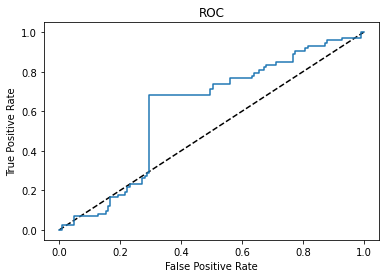

In [54]:
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
# Faliu = 1 and Não Faliu = 0
dre_10['Outras Receitas Operacionais'] = [1 if i == 'Faliu' else 0 for i in dre_10.loc[:,'Resultado']]
x,y = dre_10.loc[:,['Despesas com Pessoal','Despesas Tributárias','Outras Receitas Operacionais','Outras Despesas Operacionais',
                                      'Corrente','Participações']], dre_10.loc[:,'Outras Receitas Operacionais']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=42)
logreg = LogisticRegression()
logreg.fit(x_train,y_train)
y_pred_prob = logreg.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()

In [ ]:

dre_10 = dre_10[dre_10.ORDEM_EXERC == 'ÚLTIMO'] 
#dre_10 = dre_10[dre_10.CD_CONTA.isin(['3.04.07'])] #PESQUISA PELO CÓD

dre_10 = dre_10[dre_10.DS_CONTA.isin(['Lucro ou Prejuízo Líquido do Período','Despesas com Pessoal','Outras Despesas de Administrativas','Despesas Tributárias',
                                      'Outras Receitas Operacionais','Outras Despesas Operacionais','Resultado antes dos Tributos sobre o Lucro',
                                      'Corrente','Participações'])]
dre_10 = dre_10[['CD_CVM','CNPJ_CIA','DENOM_CIA','MOEDA','ESCALA_MOEDA','DT_INI_EXERC','DT_FIM_EXERC','DS_CONTA','VL_CONTA']]
dre_10.VL_CONTA = dre_10.VL_CONTA.astype(float)
dre_10 = dre_10.pivot_table(index=['CD_CVM','CNPJ_CIA','DENOM_CIA','MOEDA','ESCALA_MOEDA','DT_INI_EXERC','DT_FIM_EXERC'], columns=['DS_CONTA'], values='VL_CONTA').reset_index().rename_axis(None, axis=1).fillna(0)

dre_20 = pd.read_csv(f'CVM/dfp_cia_aberta_DRE_ind_2020.csv',sep=';',decimal=',',encoding='ISO-8859-1')
dre_20 = dre_20[dre_20.ORDEM_EXERC == 'ÚLTIMO']

dre_10['Resultado'] = dre_10.CNPJ_CIA.isin(dre_20.CNPJ_CIA).replace({True: 'Não Faliu', False: 'Faliu'})

DataTable(dre_10)

,CD_CVM,CNPJ_CIA,DENOM_CIA,MOEDA,ESCALA_MOEDA,DT_INI_EXERC,DT_FIM_EXERC,Corrente,Despesas Tributárias,Despesas com Pessoal,Outras Despesas Operacionais,Outras Receitas Operacionais,Participações,Resultado
0,94,92.693.019/0001-89,PANATLANTICA S.A.,REAL,MIL,2010-01-01,2010-12-31,-6693.0,0.0,0.0,0.0,1562.0,0.0,Não Faliu
1,140,92.660.604/0001-82,YARA BRASIL FERTILIZANTES,REAL,MIL,2010-01-01,2010-12-31,-258224.0,0.0,0.0,-268221.5,1544980.5,0.0,Faliu
2,701,45.987.245/0001-92,BAHEMA EDUCAÇÃO S.A.,REAL,MIL,2010-01-01,2010-12-31,0.0,0.0,0.0,-1181.0,5943.0,0.0,Não Faliu
3,906,60.746.948/0001-12,BCO BRADESCO S.A.,REAL,MIL,2010-01-01,2010-12-31,0.0,-1674092.0,0.0,-3072775.0,870353.0,0.0,Não Faliu
4,922,04.902.979/0001-44,BCO AMAZONIA S.A.,REAL,MIL,2010-01-01,2010-12-31,0.0,-59049.0,0.0,-326798.0,335918.0,-12439.0,Não Faliu
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
654,22756,11.616.840/0001-08,SAAG INVESTIMENTOS S.A.,REAL,MIL,2010-02-25,2010-12-31,0.0,0.0,0.0,0.0,179488.0,0.0,Faliu
655,23221,04.986.320/0001-13,SER EDUCACIONAL S.A.,REAL,MIL,2010-01-01,2010-12-31,-837.0,0.0,0.0,-805.0,0.0,0.0,Não Faliu
656,80020,07.857.850/0001-50,"GP INVESTMENTS, LTD.",REAL,MIL,2010-01-01,2010-12-31,0.0,0.0,0.0,-116.0,340.0,0.0,Não Faliu
657,80080,08.943.312/0001-40,AGRENCO LIMITED,REAL,MIL,2010-01-01,2010-12-31,0.0,0.0,0.0,0.0,0.0,0.0,Faliu


In [ ]:
dre_10.info

1.   Encontrar URL para CNPJ que faliram (https://github.com/fabioserpa/CNPJ-full)
2.   Split 2 dataframe faliu/não faliu
3.   Assistir aula
4.   Passar no modelo
5.   Resultado

In [ ]:
from sklearn.model_selection import train_test_split
y = dre_10.Resultado #variavel dependente
x = dre_10.drop(['Resultado'], axis=1) #variaveis independentes

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2, randon_state = 0)

TypeError: ignored

In [ ]:
#PASSAR PARAMETROS DO MACHINE LEARNING
# Baggin : Bootstrap AGGregating

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

def score_dataset (x_train, x_test, y_train, y_test):
  model = RandomForestRegressor(n_estimators=100, randon_state=0)
  model.fit(x_train, y_train)
  preds = model.predict(x_test)
  return mean_absolute_error(y_test, preds) #Quanto menor melhor

In [ ]:
#EMPRESAS EM RECUPERAÇÃO JUDICIAL PARA CLASSIFICAR NO MODELO

dre_20 = pd.read_csv(f'CVM/dfp_cia_aberta_DRE_ind_2020.csv',sep=';',decimal=',',encoding='ISO-8859-1')
dre_20 = dre_20[dre_20.ORDEM_EXERC == 'ÚLTIMO']
dre_20 = dre_20[dre_20['DENOM_CIA'].dropna().str.contains("EM RECUPERAÇÃO JUDICIAL")]
dre_20 = dre_20[['DENOM_CIA']].drop_duplicates()
dre_20

#Rascunho 

In [ ]:
d = {}
for ano in range(2010,2022):
    df = pd.read_csv(f'CVM/dfp_cia_aberta_DRE_ind_{ano}.csv',sep=';',decimal=',', encoding='ISO-8859-1')
    df = df[df.ORDEM_EXERC == 'ÚLTIMO']
    df = df[df.DS_CONTA == 'Lucro/Prejuízo do Período']
    #df = df[df.DS_CONTA == 'Lucro/Prejuízo Consolidado do Período'] #usado com 'DRE_con'
    #df['VL_CONTA'] = pd.to_numeric(df['VL_CONTA'], downcast="float")
    #df['SOMA'] = df.groupby(['CD_CVM'])['VL_CONTA'].transform('sum')
    df = df[['CD_CVM','VL_CONTA']].drop_duplicates().sort_index(1)
    d[ano] = pd.merge(dre, df, on=['CD_CVM'], how='left').fillna(0)
    dre[ano] = d[ano]['VL_CONTA']
dre.head(n=10)


In [ ]:
df = pd.read_csv(f'CVM/dfp_cia_aberta_DRE_ind_2012.csv',sep=';',decimal=',', encoding='ISO-8859-1')
df = df[df.ORDEM_EXERC == 'ÚLTIMO']
df = df.loc[df['DS_CONTA'].str.contains("Lucro/Prejuízo do Período", case=False)]
#df = df[df.CD_CONTA == '3.13']
df = df[df.CNPJ_CIA == '00.070.698/0001-11']
#df = df[df.DS_CONTA == 'Lucro/Prejuízo Consolidado do Período']
df.head(20)

In [ ]:
pd.read_csv('CVM/dfp_cia_aberta_DRE_con_2010.csv',sep=';',decimal=',',encoding='ISO-8859-1')['ORDEM_EXERC']=='ÚLTIMO'#.head(n=10)#[['CD_CVM','VL_CONTA']].head(n=10)
#df[(df['angle']

In [ ]:
#bpa = pd.read_csv('/content/DADOS/dfp_cia_aberta_BPA_con_2010-2020.csv')
#bpa.head(n=10)

In [ ]:
dre_20 = pd.read_csv('/content/CVM/dfp_cia_aberta_DRE_ind_2020.csv', sep=';', error_bad_lines=False, encoding='latin-1')
dre_21 = pd.read_csv('/content/CVM/dfp_cia_aberta_DRE_ind_2021.csv', sep=';', error_bad_lines=False, encoding='latin-1')

dre_20.head(n=10)

In [ ]:
bpa_20 = pd.read_csv('/content/CVM/dfp_cia_aberta_BPA_con_2020.csv', sep=';', error_bad_lines=False, encoding='latin-1')
bpa_20.head(n=10)

In [ ]:
#dre_20['Status'] = dre_20.CNPJ_CIA.isin(dre_21.CNPJ_CIA)
dre_20['Status'] = dre_20.equals(dre_21)
#dre_20['Status'] = np.where(dre_20["CNPJ_CIA"] == dre_21["CNPJ_CIA"], True, False)
dre_20.head(n=10)

#Filtrando

In [ ]:
#PRECISAMOS TRANSPOR OS SEGUINTES RESULTADOS DAS LINHAS, PARA COLUNAS (Os nomes de cada coluna se encontram em dre['DS_CONTA'])
dre[['DS_CONTA', 'CD_CONTA']]
#os valores da dre['VL_CONTA'], referêntes do 3.01 ao 3.99.02.01, precisam ser transpostos para Colunas. 

In [ ]:
#Dentro de cada arquivo ele trás o comparativo entre D e D-1ano. Esse filtro trás apenas o ultimo exercício, ou seja: o atual do {ano})
dre = dre[dre['ORDEM_EXERC'] == "ÚLTIMO"]

In [ ]:
# Aqui é criado uma tabela com o nome e o código CVM, e também remove arquivos duplicados
empresas = dre[['DENOM_CIA','CD_CVM','CNPJ_CIA']].drop_duplicates().set_index('CD_CVM')
DataTable(empresas)

In [ ]:
#Aqui é feito um filtro considerando o código CVM do Itsa (7617), obtido da tabela anterior (para mudar de empresa, favor alterar o número)
empresa = dre[dre['CD_CVM'] == 1023]
DataTable(empresa)

In [ ]:
dret = (dre.sort_values('DT_REFER').drop_duplicates('CNPJ_CIA',keep='last'))
DataTable(dret[['DENOM_CIA','CD_CVM','CNPJ_CIA','DT_REFER']])

In [ ]:
#Criar a coluna "ano"
dret['ano'] = dret['DT_REFER'].str[0:4]
dret['ano'] = dret['ano'].astype(int)
DataTable(dret[['DENOM_CIA','CD_CVM','CNPJ_CIA','DT_REFER', 'ano']])

In [ ]:
dret

#Treinamento e Teste

In [ ]:
#Cria 2 DataFrames a partir do filtro do ano 2020 --> dre_S -> Faliu // dre_N -> Não faliu
dre_S = dret[dret['ano'] < 2020]
dre_N = dret[dret['ano'] == 2020]

print(len(dret))
print(len(dre_S))
print(len(dre_N))

In [ ]:
dre_S

In [ ]:
#FALTA RESOLVER:
#You are running into that error because your X (dre_S) and Y(dre_N) don't have the same length!!!

caracteristicas = dre_S
previsor = dre_N
x_treinamento, x_teste, y_treinamento, y_teste = train_test_split(
	caracteristicas,
	previsor,
	test_size=0.30,
	random_state=100
)

print(len(dret))
print(len(x_treinamento))
print(len(x_teste))

#Trazendo indicadores da empresa 'X'
#OBS: precisamos criar uma forma de trazer TODAS as empresas, e não apenas 1

In [ ]:
#Retorna uma tabela relacional dos códigos de descrição dos valores financeiros filtrada por data
DataTable(empresa[['DT_REFER', 'DENOM_CIA','CD_CONTA', 'DS_CONTA', 'VL_CONTA']].drop_duplicates().set_index('DT_REFER'))


#Com o código de descrição em mãos, podemos fazer os devidos filtros individualmente, para fins de cáculos financeiros

In [ ]:
#Filtrando pelo LPA - "PN" e por data
LPA = empresa[empresa['CD_CONTA'] == '3.99.01.02']
LPA.index = pd.to_datetime(conta['DT_REFER'])
LPA.head(12)

In [ ]:
Rct_Liq = empresa[empresa['CD_CONTA'] == '3.04']
Lucro_Liq = empresa[empresa['CD_CONTA'] == '3.11']

In [ ]:
LPA['VL_CONTA']
Rct_Liq['VL_CONTA']
Lucro_Liq['VL_CONTA']

In [ ]:
prices = yf.download('itsa4.SA', start='2011-01-01')[['Adj Close', 'Close']]
prices

In [ ]:
#RESOLVER ESSE PROBLEMA: ELE ESTA SUBSCREVENDO AO INVES DE INCLUIR NOVAS COLUNAS POR CONTA DO ['VL_CONTA'] SER O MESMO NOME DE INDICADOR

indicadores = prices.join(LPA['VL_CONTA'], how='outer')
indicadores.rename({'VL_CONTA':'LPA'}, axis=1, inplace=True)
#indicadores = prices.join(Rct_Liq['VL_CONTA'], how='outer')
#indicadores.rename({'VL_CONTA':'Rct_Liq'}, axis=1, inplace=True) 
#indicadores = prices.join(Lucro_Liq['VL_CONTA'], how='outer')
#indicadores.rename({'VL_CONTA':'Lucro_Liq'}, axis=1, inplace=True) 
indicadores


In [ ]:

indicadores.fillna(method='ffill',inplace=True)
indicadores.dropna(inplace=True)

In [ ]:
indicadores

In [ ]:
indicadores['PL'] = indicadores ['Close'] /  indicadores ['LPA']
indicadores['PL_Ajustado'] = indicadores ['Adj Close'] /  indicadores ['LPA']
#indicadores ['Marg_Liq'] = indicadores['Lucro_Liq'] / indicadores['Rct_Liq']

In [ ]:
fig = go.Figure()
#fig.add_trace(go.Scatter(x= indicadores.index, y= prices['Adj Close'], name='Preço'))
#fig.add_trace(go.Scatter(x= indicadores.index, y= prices['Close'], name='Preço'))
fig.add_trace(go.Scatter(x= indicadores.index, y= indicadores['PL'], name='Preço'))
fig.add_trace(go.Scatter(x= indicadores.index, y= indicadores['PL_Ajustado'], name='Preço'))